## Preparation

In [234]:
import pandas as pd
import numpy as np

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys
import matplotlib.pyplot as plt

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import ReducedRegressionForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA

from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformers.single_series.detrend import Detrender,Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster

from sklearn.base import clone
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [18]:
from sktime.datasets import load_airline
airlines = load_airline()

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1abf106bb00>)

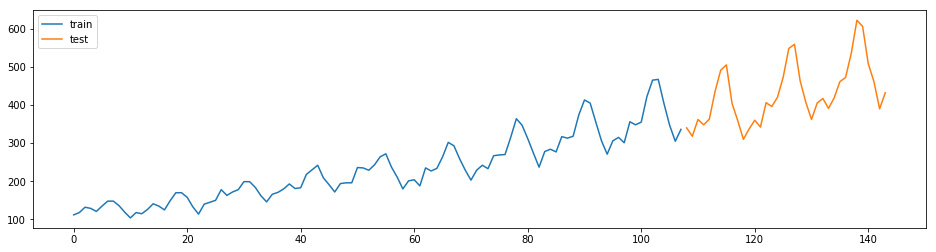

In [17]:
FH = TEST_SIZE = 36
fh = np.arange(1,FH+1)
train, test = temporal_train_test_split(airlines, test_size=TEST_SIZE)
plot_ys(train,test,labels=['train','test'])

## Naive Forecaster

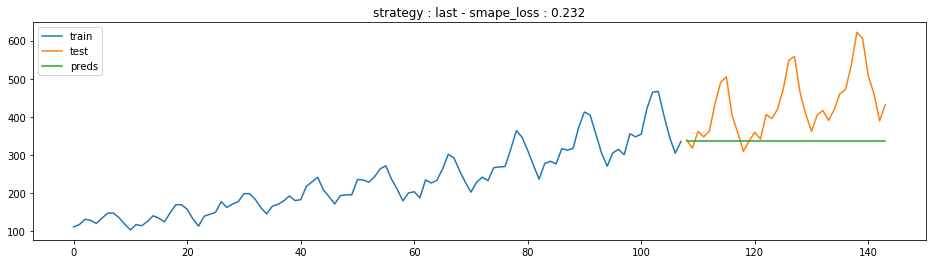

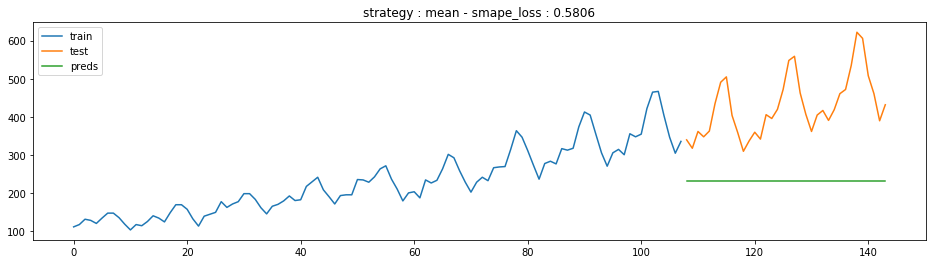

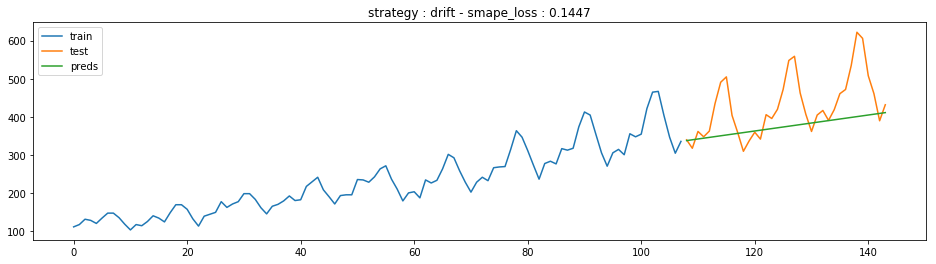

In [19]:
strategies = ['last','mean','drift']
for strategy in strategies:
    forecaster = NaiveForecaster(strategy = strategy)
    forecaster.fit(train)
    y_pred = forecaster.predict(fh)
    plot_ys(train,test,y_pred,labels=['train','test','preds'])
    plt.title(f'strategy : {strategy} - smape_loss : {round(smape_loss(test,y_pred),4)}')

## Tuning

### Tune Forecaster

In [44]:
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV

In [33]:
forecaster = ExponentialSmoothing()

In [39]:
forecaster_param_grid = {
    'trend':['add','mul'],
    'seasonal':['add','mul'],
    'sp':[12]
}

In [40]:
cv = SlidingWindowSplitter(initial_window=int(len(train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)
gscv.fit(train)
y_pred = gscv.predict(fh)

C:\Users\Takis\Anaconda3\lib\site-packages\sktime\forecasting\exp_smoothing.py:99: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  seasonal_periods=self.sp,
C:\Users\Takis\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\Takis\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning
C:\Users\Takis\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1136: FutureWarning: use_basinhopping is deprecated. Set optimization method using 'method'. This option will be removed after 0.13 is released.
  FutureWarning,
C:\Users\Takis\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ 

In [43]:
gscv.best_params_

{'seasonal': 'mul', 'sp': 12, 'trend': 'add'}

0.05144409835065696

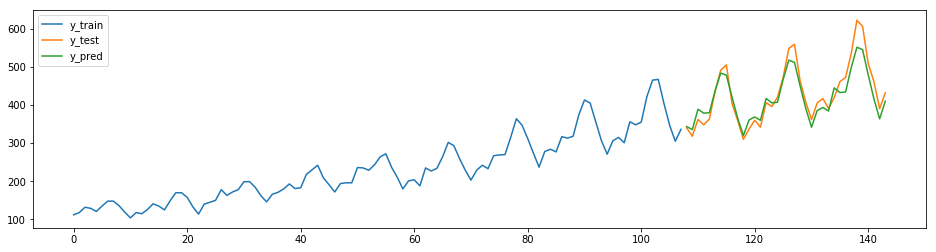

In [42]:
plot_ys(train, test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(test, y_pred)

### Tune Forecaster & Reduced Regressor

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [52]:
forecaster_param_grid = {"window_length": [5, 10, 15]}
regressor_param_grid = {"n_estimators": [100, 200, 300]}

In [53]:
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=10)

In [55]:
cv = SlidingWindowSplitter(initial_window=int(len(train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

In [56]:
gscv.fit(train)
y_pred = gscv.predict(fh)

In [57]:
gscv.best_params_

{'window_length': 15}

In [79]:
gscv.best_forecaster_

RecursiveRegressionForecaster(regressor=GridSearchCV(estimator=RandomForestRegressor(),
                                                     param_grid={'n_estimators': [100,
                                                                                  200,
                                                                                  300]}),
                              window_length=15)

In [80]:
gscv.best_forecaster_.regressor_.best_params_

{'n_estimators': 100}

In [75]:
pd.DataFrame(gscv.cv_results_)

,mean_fit_time,mean_score_time,param_window_length,params,mean_test_sMAPE,rank_test_sMAPE
0,3.562998,0.992969,5,{'window_length': 5},0.289887,3
1,3.325522,1.058000,10,{'window_length': 10},0.267514,2
2,3.459998,0.611999,15,{'window_length': 15},0.238130,1


## Pipelines

In [86]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformers.single_series.detrend import Detrender,Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster

### Detrending

In [126]:
model = PolynomialTrendForecaster(degree=1)
transformer = Detrender(model)

yt = transformer.fit_transform(train)
trendline = model.fit(train).predict(fh=-np.arange(len(train)))

plot_ys(train,trendline,yt,labels=['series','trend','detrended'])

### Pipelining

0.05506535074511815

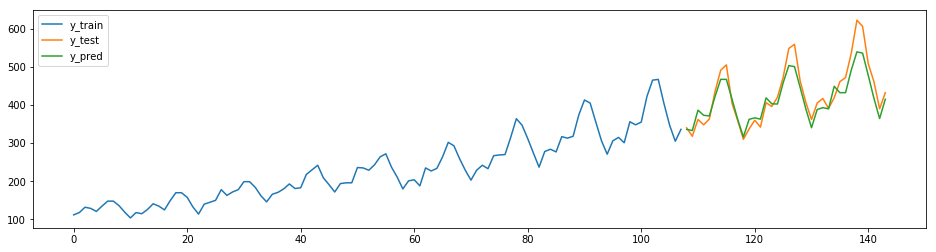

In [130]:
forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
    ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ("forecast", ReducedRegressionForecaster(regressor=regressor, window_length=12, strategy="recursive"))
])
forecaster.fit(train)
y_pred = forecaster.predict(fh)
plot_ys(train, test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(test, y_pred)

## WORK IN PROGRESS

## Pipeline Tuning

In [246]:
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

listOfRegressors = [KNeighborsRegressor(),ElasticNet(),
                    RandomForestRegressor(),ExtraTreesRegressor()]

listOfRegressorNames = [x.__class__.__name__ for x in listOfRegressors]

In [316]:
regressor_estimators = listOfRegressors
# statistical_estimators = [AutoARIMA(suppress_warnings=True, sp=12),AutoETS(sp=12)]
# estimators = statistical_estimators + regressor_estimators
estimators = regressor_estimators
len(estimators)

4

In [317]:
for e in estimators:
    print(e.__class__.__name__)

KNeighborsRegressor
ElasticNet
RandomForestRegressor
ExtraTreesRegressor


In [318]:
hpo_distributions = {
#     'AutoARIMA':{'sp':[12]},
#     'AutoETS':{'trend':['add','mul'],'seasonal':['add','mul'],'sp':[12]},
    'KNeighborsRegressor': {'n_neighbors':np.arange(5,30,5)},
    'ElasticNet': {'alpha':np.arange(0.0,1.1,0.1)},
    'RandomForestRegressor': {'n_estimators':[100,200,300,400,500]},
    'ExtraTreesRegressor': {'n_estimators':[100,200,300,400,500]}
}

forecaster_param_grid = {"forecaster__window_length": [5,10,15,20,25]}

In [319]:
RS_N_ITER = 3
cv_results = []
cv = SlidingWindowSplitter(initial_window=int(len(train) * 0.8))
pipeline = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
    ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1)))
])

In [ ]:
for estimator in estimators:
    
#     temp_pipeline = clone(pipeline)
    temp_pipeline = pipeline = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
    ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1)))
    ])
    
    algo_name = estimator.__class__.__name__
    fpi = forecaster_pipeline_idenditifier = 'forecaster__regressor__estimator'#'forecaster'
    print(algo_name)
    
    if algo_name not in hpo_distributions.keys():
        print(f'There was no parameter distribution for {algo_name}')
    else:
        algo_distr = {"__".join([fpi,k]):v for k,v in hpo_distributions.get(algo_name).items()}
        algo_distr = hpo_distributions.get(algo_name).items()

        if algo_name in listOfRegressorNames:
            
            print(f'>> Reduced Regressor : {algo_name}')
            temp_regressor = RandomizedSearchCV(estimator, n_iter= RS_N_ITER, param_distributions=algo_distr)
            temp_forecaster = ReducedRegressionForecaster(regressor=temp_regressor, strategy="recursive")
            temp_pipeline.steps.append(("forecaster", temp_forecaster))
            hpocv = ForecastingGridSearchCV(temp_pipeline, cv=cv, param_grid = forecaster_param_grid)

# ================================ WORK IN PROGRESS ================================
            hpocv.fit(train)
#             y_pred = hpocv.predict(fh)
#             print(f'smape_loss : {smape_loss(test,y_pred)}')
#             print(f'forecaster params : {hpocv.best_params_}')
#             print(f'best regressor params : {hpocv.best_forecaster_.regressor_.best_params_}')
#             cv_results.append(pd.DataFrame(hpocv.cv_results_))


In [ ]:
hpocv.get_params()

In [ ]:
temp_regressor.get_params()

In [ ]:
temp_forecaster.get_params()

## Ensemble Forecasting